# Student Name: Zhongyue Xing

# Preface

In this problem we consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" and "transplant". 

We assume that the Markov property holds. There are three additional states of the Markov Decision Process: "Pretransplant Death", "Posttransplant Life" and "Posttransplant Death" with no actions available. Assume that the length of episodes is T=50. "Pretransplant Death" and "Posttransplant Death" are absorbing states (time stops).

If patient selects "wait", the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Pretransplant Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Pretransplant Death  
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Pretransplant Death

If a patient selects "transplant" in Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there is the transition  
5) "Posttransplant Life"->"Posttransplant Death"  

Assume that   

P(Stage (k+1)|Stage k, "wait")=0.10 for k=1,2,...,17  
P(Stage (k-1)|Stage k, "wait")=0.02 for k=2,3,...,18  

P(Pretransplant Death|Stage k, "wait")=k*c for k=1,2,...,18 and some constant c.  

P(Stage k|Stage k, "wait")=0.9-kc for k=1   
P(Stage k|Stage k, "wait")=0.98-kc for k=18   
P(Stage k|Stage k, "wait")=0.88-kc for k=2,...,17   

Further, assume that   
P(Posttransplant Death|Posttransplant Life)= 4*c for the same constant c.


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


# Problem 1 (20 points)
Assume c = 0.01. Using the Monte Carlo control with $\varepsilon$-soft policy (without Exploring starts), estimate the policy for each State k, k=1,2,...,18. Use $\varepsilon$ = 0.05.

In [87]:
import numpy as np
from random import randint

ESLD_STAGES = range(1, 19)

class ESLD:
    def __init__(self, stage, c = 0.01):
        """
        Generate an ESLD model for a patient in stage 1-18 of ESLD.

        If the patient is outside of stage 1-18, the patient is either dead
        or in "posttransplant life stage", which is represented as stage 0.

        Death is the terminal state of this model, it is stored as self.state = None.
        Initialising a dead patient is not a valid input.
        
        """
        assert stage in range(19), "stage must be 0-18 for live patient"
        self.state = stage
        self.c = c
        self.time = 0

    def admissible_actions(self):
        """ return all admissible actions for a state in the form of a list """
        if self.state in ESLD_STAGES:
            return [0, 1] # 0 correspond to "wait", 1 correspond to "transplant"
        elif self.state == 0:
            return [None]
        else:
            raise (ImplementationError, "state should not exist")
    
    def is_terminal(self):
        return self.state == None

    def get_reward(self, action):
        if action == None:
            # posttransplant life
            assert self.state == 0, "action only valid for post-transplant life"
            self.state = np.random.choice([0, None], p = [1 - 4*self.c, 4*self.c])

            if self.state == 0:
                reward = 0.2
            else:
                # posttransplant death
                reward = 0

        elif action == 1:
            # transplant action
            self.state = 0
            reward = 0.2

        elif action == 0:
            # wait action
            new_states = [self.state-1, self.state, self.state+1, None]
            p_new_states = [0.02, 0.88-self.c*self.state, 0.1, self.c*self.state]
    
            if self.state == 1:
                p_new_states[1] += 0.02
                del new_states[0]
                del p_new_states[0]
            elif self.state == 18:
                p_new_states[1] += 0.1
                del new_states[-2]
                del p_new_states[-2]

            self.state = np.random.choice(new_states, p = p_new_states)

            if self.state == None:
                # pretransplant death
                reward = 0
            else:
                reward = 1

        else:
            raise (TypeError, "action", action, "is invalid for", self.state)

        self.time += 1
        return reward


def generate_ESLD_episode(policy):
    stage = randint(1, 18)
    env = ESLD(stage)
    record = {"s":[], "a":[], "r":[]}
    first_appearance = {}

    while True:
        record["s"].append(env.state)

        selected_action = np.random.choice(env.admissible_actions(), p = policy[env.state])
        record["a"].append(selected_action)

        if (env.state, selected_action) not in first_appearance.keys():
            first_appearance[(env.state, selected_action)] = env.time

        reward = env.get_reward(selected_action)
        record["r"].append(reward)

        if env.is_terminal() or env.time >= 100: # patient lives no longer than 100 years post diagnosis
            return record, first_appearance



def on_policy_esoft_estimate(n_eps = 10000, gamma = 0.97, epsilon = 0.05):
    policy = {state:[0.5, 0.5] for state in ESLD_STAGES}
    policy[0] = [1]  # policy for posttransplant life is 100% pass
    Q = {state:[0, 0] for state in ESLD_STAGES}
    results = {state:[[], []] for state in ESLD_STAGES}

    for i in range(n_eps):
        episode, first_appearance = generate_ESLD_episode(policy)
        G = 0
        t_max = len(episode["s"])
        for t in range(-1, -t_max-1, -1):
            G = gamma*G + episode["r"][t]  # reward time offset is embeded
    
            if (t_max + t) == first_appearance[(episode["s"][t], episode["a"][t])] and episode["s"][t] in ESLD_STAGES:

                state = episode["s"][t]
                action = episode["a"][t]

                results[state][action].append(G)
                Q[state][action] = np.mean(results[state][action])
                
                # only action 0 (wait) and 1 (transplant) are admissible
                if Q[state][1] > Q[state][0]:
                    best_actions = 1
                elif Q[state][1] == Q[state][0]:
                    # random tie break
                    best_actions = randint(0, 1)
                else:
                    best_actions = 0

                for a in range(0, 2):
                    if a == best_actions:
                        policy[state][a] = 1 - epsilon/2
                    else:
                        policy[state][a] = epsilon/2

    return policy

print(on_policy_esoft_estimate(n_eps = 10000))

{1: [0.975, 0.025], 2: [0.975, 0.025], 3: [0.975, 0.025], 4: [0.975, 0.025], 5: [0.975, 0.025], 6: [0.975, 0.025], 7: [0.975, 0.025], 8: [0.975, 0.025], 9: [0.975, 0.025], 10: [0.975, 0.025], 11: [0.975, 0.025], 12: [0.975, 0.025], 13: [0.975, 0.025], 14: [0.975, 0.025], 15: [0.975, 0.025], 16: [0.975, 0.025], 17: [0.975, 0.025], 18: [0.975, 0.025], 0: [1]}


# Problem 2 (5 points)
Run the algorithm you developed in Problem 1 for c =0.001,0.002,0.003,...,0.040. For each c, identify the minimal k such that the agent will select "transplant" (i.e. minimal k such that policy $\pi$(trsansplant|Stage k) > 0.5) in State k. Plot this k versus c. Discuss the result.

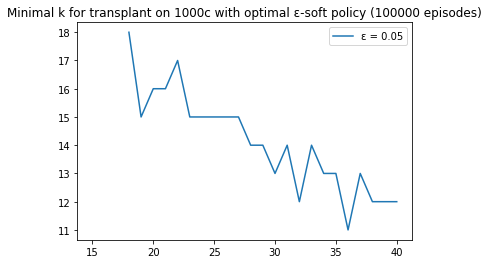

([<matplotlib.axis.XTick at 0x260d0fe0390>,
 <a list of 18 Text xticklabel objects>)

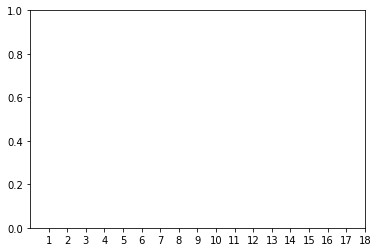

In [86]:
import numpy as np
from random import randint

ESLD_STAGES = range(1, 19)

class ESLD:
    def __init__(self, stage, c = 0.01):
        """
        Generate an ESLD model for a patient in stage 1-18 of ESLD.

        If the patient is outside of stage 1-18, the patient is either dead
        or in "posttransplant life stage", which is represented as stage 0.

        Death is the terminal state of this model, it is stored as self.state = None.
        Initialising a dead patient is not a valid input.
        
        """
        assert stage in range(19), "stage must be 0-18 for live patient"
        self.state = stage
        self.c = c
        self.time = 0

    def admissible_actions(self):
        """ return all admissible actions for a state in the form of a list """
        if self.state in ESLD_STAGES:
            return [0, 1] # 0 correspond to "wait", 1 correspond to "transplant"
        elif self.state == 0:
            return [None]
        else:
            raise (ImplementationError, "state should not exist")
    
    def is_terminal(self):
        return self.state == None

    def get_reward(self, action):
        if action == None:
            # posttransplant life
            assert self.state == 0, "action only valid for post-transplant life"
            self.state = np.random.choice([0, None], p = [1 - 4*self.c, 4*self.c])

            if self.state == 0:
                reward = 0.2
            else:
                # posttransplant death
                reward = 0

        elif action == 1:
            # transplant action
            self.state = 0
            reward = 0.2

        elif action == 0:
            # wait action
            new_states = [self.state-1, self.state, self.state+1, None]
            p_new_states = [0.02, 0.88-self.c*self.state, 0.1, self.c*self.state]
    
            if self.state == 1:
                p_new_states[1] += 0.02
                del new_states[0]
                del p_new_states[0]
            elif self.state == 18:
                p_new_states[1] += 0.1
                del new_states[-2]
                del p_new_states[-2]

            self.state = np.random.choice(new_states, p = p_new_states)

            if self.state == None:
                # pretransplant death
                reward = 0
            else:
                reward = 1

        else:
            raise (TypeError, "action", action, "is invalid for", self.state)

        self.time += 1
        return reward


def generate_ESLD_episode(c, policy):
    stage = randint(1, 18)
    env = ESLD(stage, c = c)
    record = {"s":[], "a":[], "r":[]}
    first_appearance = {}

    while True:
        record["s"].append(env.state)

        selected_action = np.random.choice(env.admissible_actions(), p = policy[env.state])
        record["a"].append(selected_action)

        if (env.state, selected_action) not in first_appearance.keys():
            first_appearance[(env.state, selected_action)] = env.time

        reward = env.get_reward(selected_action)
        record["r"].append(reward)

        if env.is_terminal() or env.time >= 100: # patient lives no longer than 100 years post diagnosis
            return record, first_appearance



def on_policy_esoft_estimate(c, n_eps = 10000, gamma = 0.97, epsilon = 0.05):
    policy = {state:[0.5, 0.5] for state in ESLD_STAGES}
    policy[0] = [1]  # policy for posttransplant life is 100% pass
    Q = {state:[0, 0] for state in ESLD_STAGES}
    results = {state:[[], []] for state in ESLD_STAGES}

    for i in range(n_eps):
        episode, first_appearance = generate_ESLD_episode(c, policy)
        G = 0
        t_max = len(episode["s"])
        for t in range(-1, -t_max-1, -1):
            G = gamma*G + episode["r"][t]  # reward time offset is embeded
    
            if (t_max + t) == first_appearance[(episode["s"][t], episode["a"][t])] and episode["s"][t] in ESLD_STAGES:

                state = episode["s"][t]
                action = episode["a"][t]

                results[state][action].append(G)
                Q[state][action] = np.mean(results[state][action])
                
                # only action 0 (wait) and 1 (transplant) are admissible
                if Q[state][1] > Q[state][0]:
                    best_actions = 1
                elif Q[state][1] == Q[state][0]:
                    # random tie break
                    best_actions = randint(0, 1)
                else:
                    best_actions = 0

                for a in range(0, 2):
                    if a == best_actions:
                        policy[state][a] = 1 - epsilon/2
                    else:
                        policy[state][a] = epsilon/2

    return policy


n_eps = 10000
k = []
for c in range(1, 41):
    policy = on_policy_esoft_estimate(c/1000, n_eps = n_eps)

    for key in ESLD_STAGES:
        if policy[key][1] > 0.5:
            k.append(key)
            break
    if len(k) < c:
        k.append(float('inf'))

from matplotlib import pyplot as plt
plt.plot(range(1,41), k, label='ε = 0.05')
plt.title('Minimal k for transplant on 1000c with optimal ε-soft policy ({} episodes)'.format(n_eps))
plt.legend()
plt.show()
plt.xticks(np.arange(1, 19, 1.0))

With respect to increase in c, the probability of death increases for "transplant" action at the rate of 4 while the probability of death for "wait" action increases proportionally to k. The expected reward (G) can be largely influenced by the rate of death. For large k, the chance of death for "wait" action will exceed the chance of death for "transplant" significantly, making the "transplant" action generate higher expected rewards. Thus the minimal k with transplant policy is expected to decrease with respect to c, since more wait actions with relatively lower k value overtake the "transplant" action by their high probability of death. The result may not be strictly decreasing due to chance.